# Desafio - Boosting Classifiers

- Para esta sesión trabajaremos con una base de datos sobre rotación de clientes en una compañia de telecomunicaciones. El archivo contiene 3333 registros y 20 atributos. El vector objetivo a modelar es la tasa de rotación entre los clientes de una compañia de telecomunicaciones churn. Los atributos existentes hacen referencia a características de la cuenta de cada cliente.

## Ejercicio 1: Preprocesamiento
- Grafique el comportamiento distributivo de los atributos y de la variable dependiente. Reporte brevemente el comportamiento de las variables. 
- En base al comportamiento de los atributos, considere si es necesario implementar alguna recodificación o transformación de atributo. Algunas normas a seguir:
    * Para las variables categóricas, recodifíquelas en variables binarias.
    * Para aquellas variables numéricas que presenten alto sesgo, pueden transformarlas con su logaritmo.

In [1]:
# "Librerías" Básicas

import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas de classificación
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Modelo
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('churn_train.csv').drop(columns='Unnamed: 0')
print('El dataset tiene: {} filas y {} columnas '.format(df.shape[0], df.shape[1]))
df.sample()

El dataset tiene: 3333 filas y 20 columnas 


state  account_length      area_code international_plan voice_mail_plan  \
1299    UT              49  area_code_415                 no              no   

      number_vmail_messages  total_day_minutes  total_day_calls  \
1299                      0              266.3               90   

      total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
1299             45.27              207.8              117             17.66   

      total_night_minutes  total_night_calls  total_night_charge  \
1299                205.0                 98                9.23   

      total_intl_minutes  total_intl_calls  total_intl_charge  \
1299                14.0                 2               3.78   

      number_customer_service_calls churn  
1299                              2   yes

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
state                            3333 non-null object
account_length                   3333 non-null int64
area_code                        3333 non-null object
international_plan               3333 non-null object
voice_mail_plan                  3333 non-null object
number_vmail_messages            3333 non-null int64
total_day_minutes                3333 non-null float64
total_day_calls                  3333 non-null int64
total_day_charge                 3333 non-null float64
total_eve_minutes                3333 non-null float64
total_eve_calls                  3333 non-null int64
total_eve_charge                 3333 non-null float64
total_night_minutes              3333 non-null float64
total_night_calls                3333 non-null int64
total_night_charge               3333 non-null float64
total_intl_minutes               3333 non-null float64
total_intl_calls           

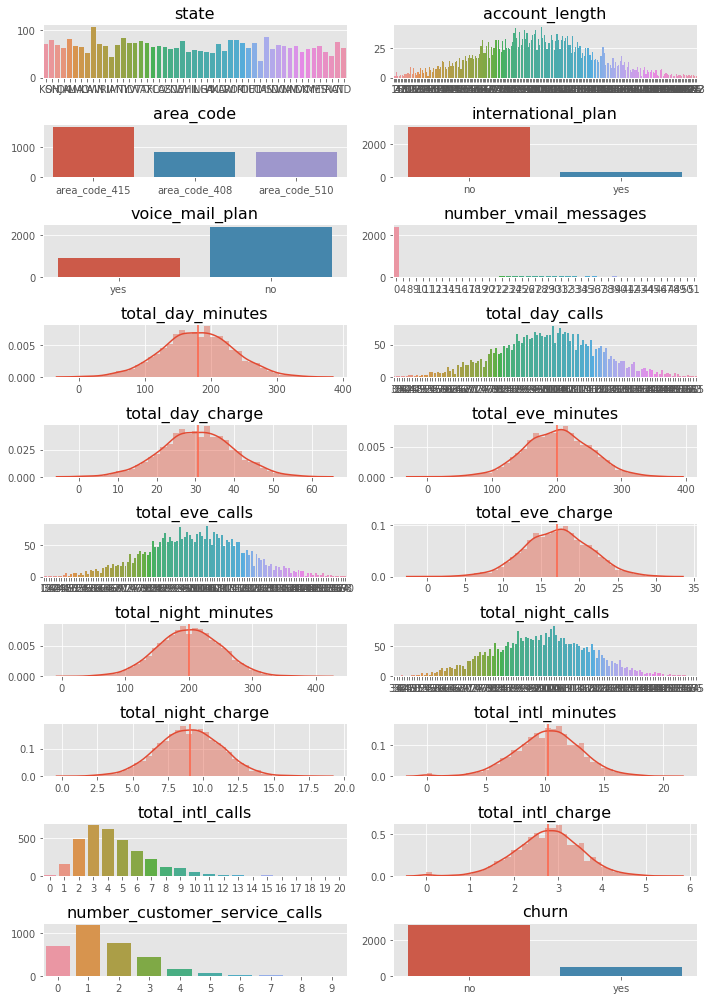

In [4]:
plt.rcParams['figure.figsize']=(10, 14)

for index, (colname, serie) in enumerate(df.iteritems()):
    plt.subplot(10, 2, index + 1)
    if pd.api.types.is_float_dtype(serie) is True:
        sns.distplot(serie)
        plt.axvline(np.mean(serie), color='tomato')
    elif pd.api.types.is_integer_dtype(serie) is True:
        sns.countplot(serie)
    elif pd.api.types.is_object_dtype(serie) is True:
        sns.countplot(serie)
    plt.title(colname, fontsize=16)
    plt.xlabel('')  
    plt.ylabel('')
    plt.tight_layout()

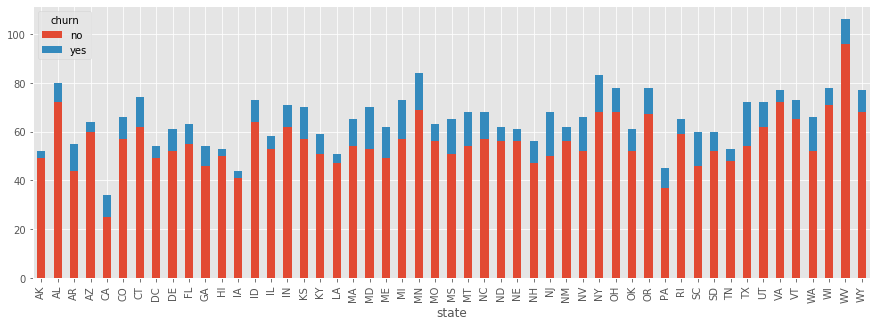

In [5]:
plt.rcParams['figure.figsize']=(15, 5)

df.groupby(['state', 'churn']).size().unstack().plot(kind='bar', stacked=True)

### Comentarios

-A partir de los gráficos sólo se recodificarán las variables categóricas. La mayoria de las clases presentan una distribución normal excepto 3 columnas. Sin embargo, estas variables no son continuas para poder aplicar logaritmo.

In [6]:
#recodificar variables que son objetos en distintas columnas
for colname, serie in df.iteritems():
    if serie.dtype == 'object':
        df = pd.concat([df, pd.get_dummies(serie, drop_first=True,prefix=colname)], axis=1) 
        df = df.drop(columns = colname)

In [7]:
df

account_length  number_vmail_messages  total_day_minutes  \
0                128                     25              265.1   
1                107                     26              161.6   
2                137                      0              243.4   
3                 84                      0              299.4   
4                 75                      0              166.7   
...              ...                    ...                ...   
3328             192                     36              156.2   
3329              68                      0              231.1   
3330              28                      0              180.8   
3331             184                      0              213.8   
3332              74                     25              234.4   

      total_day_calls  total_day_charge  total_eve_minutes  total_eve_calls  \
0                 110             45.07              197.4               99   
1                 123             27.47              195.5              103   
2                 114             41.38              121.2              110   
3                  71             50.90               61.9               88   
4                 113             28.34              148.3              122   
...               ...               ...                ...              ...   
3328               77             26.55              215.5              126   
3329               57             39.29              153.4               55   
3330              109             30.74              288.8               58   
3331              105             36.35              159.6               84   
3332              113             39.85              265.9               82   

      total_eve_charge  total_night_minutes  total_night_calls  ...  state_VT  \
0                16.78                244.7                 91  ...         0   
1                16.62                254.4                103  ...         0   
2                10.30                162.6                104  ...         0   
3                 5.26                196.9                 89  ...         0   
4                12.61                186.9                121  ...         0   
...                ...                  ...                ...  ...       ...   
3328             18.32                279.1                 83  ...         0   
3329             13.04                191.3                123  ...         0   
3330             24.55                191.9                 91  ...         0   
3331             13.57                139.2                137  ...         0   
3332             22.60                241.4                 77  ...         0   

      state_WA  state_WI  state_WV  state_WY  area_code_area_code_415  \
0            0         0         0         0                        1   
1            0         0         0         0                        1   
2            0         0         0         0                        1   
3            0         0         0         0                        0   
4            0         0         0         0                        1   
...        ...       ...       ...       ...                      ...   
3328         0         0         0         0                        1   
3329         0         0         1         0                        1   
3330         0         0         0         0                        0   
3331         0         0         0         0                        0   
3332         0         0         0         0                        1   

      area_code_area_code_510  international_plan_yes  voice_mail_plan_yes  \
0                           0                       0                    1   
1                           0                       0                    1   
2                           0                       0                    0   
3                           0                       1                    0   
4                       

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 70 columns):
account_length                   3333 non-null int64
number_vmail_messages            3333 non-null int64
total_day_minutes                3333 non-null float64
total_day_calls                  3333 non-null int64
total_day_charge                 3333 non-null float64
total_eve_minutes                3333 non-null float64
total_eve_calls                  3333 non-null int64
total_eve_charge                 3333 non-null float64
total_night_minutes              3333 non-null float64
total_night_calls                3333 non-null int64
total_night_charge               3333 non-null float64
total_intl_minutes               3333 non-null float64
total_intl_calls                 3333 non-null int64
total_intl_charge                3333 non-null float64
number_customer_service_calls    3333 non-null int64
state_AL                         3333 non-null uint8
state_AR                     

## Ejercicio 2: Comparación de AdaBoost y Gradient Boosting

- Entrene los clasificadores AdaBoost y Gradient Boosting para mejorar su capacidad predictiva en la medida de lo posible. Para ello, implemente una búsqueda de grilla con las siguientes especificaciones:

### Metodo: 

Se selecciona la métrica recall, debido a que se requiere capturar la mayor cantidad de clientes que deciden fugarse (a traves de optimizar su recall score)

In [9]:
target_vector = df['churn_yes'] # Variable churn como objetivo
var_attributes = df.drop(columns=['churn_yes']) # las demas atributos
X_train, X_test, y_train, y_test = train_test_split(var_attributes, target_vector, test_size=.33,random_state=93177)

## AdaBoost

In [10]:
grilla_ada = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 500, 1000, 2000]
}

grid_ada = GridSearchCV(AdaBoostClassifier(), grilla_ada,
                        n_jobs=-1,
                        cv=5,
                        verbose=5,
                        scoring="recall"
                        )
grid_ada = grid_ada.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   33.5s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   53.2s finished


In [11]:
y_hat = grid_ada.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       937
           1       0.61      0.43      0.51       163

    accuracy                           0.88      1100
   macro avg       0.76      0.69      0.72      1100
weighted avg       0.86      0.88      0.87      1100



In [12]:
print('Los mejores parametros son: {} '.format(grid_ada.best_params_)) ## Mejores parámetros para AdaBoostClassifier
print('Mejor score del GridSearch para AdaBoostClassifier: {} '.format(grid_ada.best_score_))

Los mejores parametros son: {'learning_rate': 0.5, 'n_estimators': 2000} 
Mejor score del GridSearch para AdaBoostClassifier: 0.38440438871473354 


## Gradient Boosting

In [13]:
grilla_gb = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 500, 1000, 2000],
    'subsample': [0.1, 0.5, 0.9]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(), grilla_gb,
                        n_jobs=-1,
                        cv=5,
                        verbose=5,
                        scoring="recall"
                        )

grid_gb = grid_gb.fit(X_train, y_train)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  4.5min finished


In [14]:
y_hat = grid_gb.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       937
           1       0.45      0.66      0.53       163

    accuracy                           0.83      1100
   macro avg       0.69      0.76      0.71      1100
weighted avg       0.86      0.83      0.84      1100



In [15]:
print('Los mejores parametros son: {} '.format(grid_gb.best_params_)) ## Mejores parámetros para AdaBoostClassifier
print('Mejor score del GridSearch para GradientBoostingClassifier: {} '.format(grid_gb.best_score_))

Los mejores parametros son: {'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.1} 
Mejor score del GridSearch para GradientBoostingClassifier: 0.7125153940886699 


## Ejercicio 3: Principales factores asociados
- Con el mejor modelo, reporte la importancia relativa de los atributos y comente cuáles son los que aumentan la probabilidad de fuga en los clientes.
- tip: Pueden implementar la función plot_importance que se encuentra en la lectura de Bagging y Random Forest.

In [16]:
def plot_importance(fit_model, feat_names):
    """Entrada: El mejor modelo con los nombres de los atributos
    fit_model: TODO
    :returns: TODO

    """
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    plt.title("Feature importance")
    plt.barh(range(len(feat_names)), tmp_importance[sort_importance])
    plt.yticks(range(len(feat_names)), names, rotation=0)

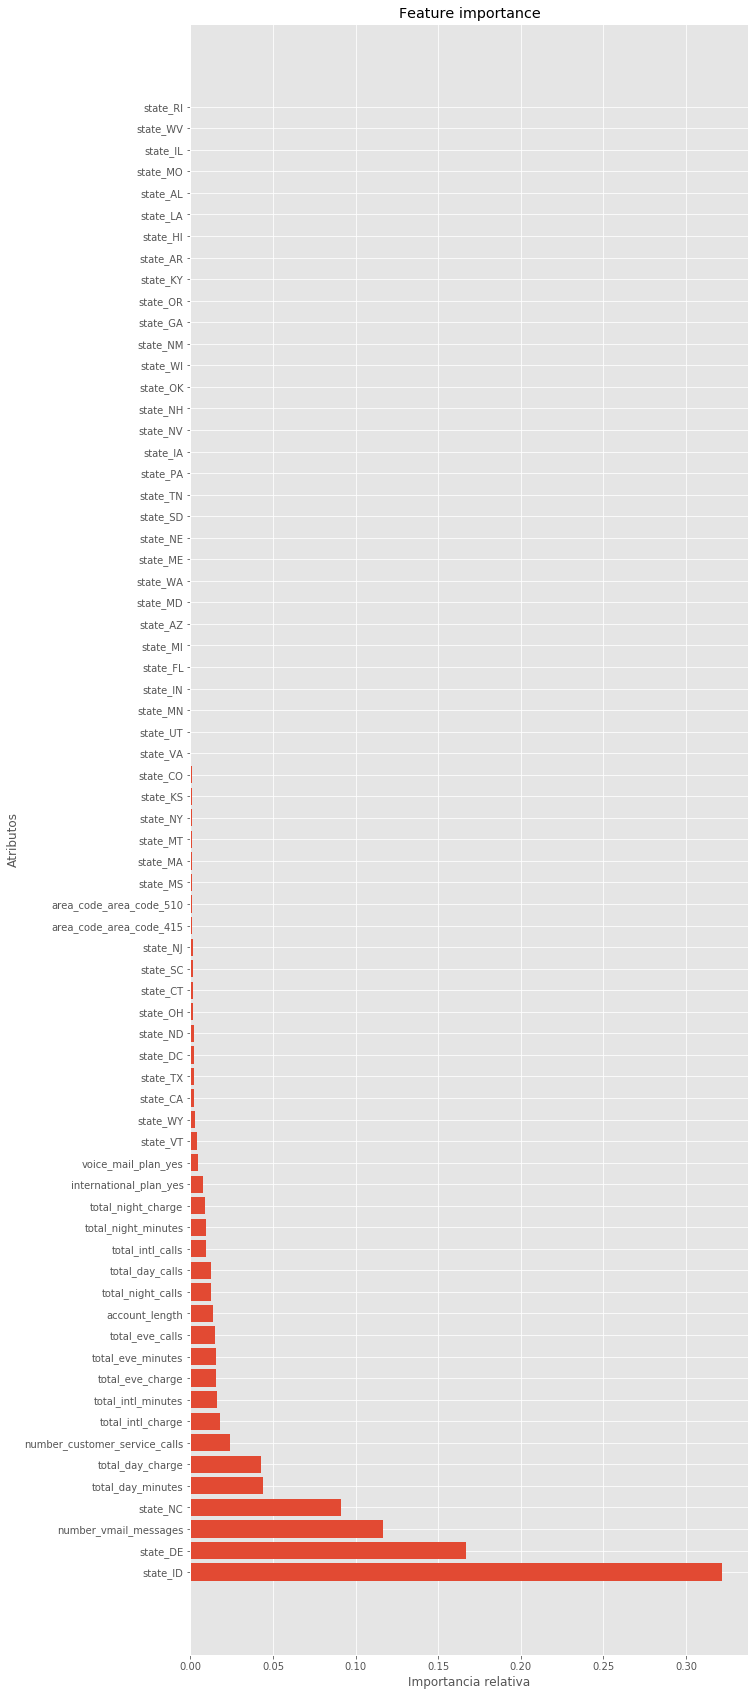

In [17]:
plt.rcParams['figure.figsize'] = (10, 30)
plot_importance(grid_gb.best_estimator_,var_attributes.columns)
plt.xlabel("Importancia relativa");
plt.ylabel('Atributos');

In [18]:
def top_ten(fit_model, feat_names):
    tmp_importance = fit_model.feature_importances_
    sort_importance = np.argsort(tmp_importance)[::-1]
    names = [feat_names[i] for i in sort_importance]
    top_ten = names[:10]
    return(top_ten)

In [19]:
top_ten(grid_gb.best_estimator_,var_attributes.columns)

['state_ID',
 'state_DE',
 'number_vmail_messages',
 'state_NC',
 'total_day_minutes',
 'total_day_charge',
 'number_customer_service_calls',
 'total_intl_charge',
 'total_intl_minutes',
 'total_eve_charge']

### Comentarios:

- Los que aumentan la probabilidad de fuga en los clientes estan asociados a las cuentas que tienen planes internacionales, total carga a la cuenta, y numero de llamadas al servicio del cliente(podria darse por la insatisfacción de su cuenta)

## Ejercicio 4: Probabilidad de fuga
- El gerente general necesita saber en qué estados hay una mayor probabilidad de fuga de clientes. Para ello, identifique los tres estados con una mayor probabilidad de fuga.
- Implemente el modelo predictivo con el archivo churn_test.csv.
- Recuerde que para obtener la probabilidad de clase, debe utilizar la función predict_proba del modelo.

In [20]:
#generar base de datos para predicción recodificada

churn_pred = pd.read_csv('churn_test.csv').drop(columns='Unnamed: 0')
X_test_csv = pd.read_csv('churn_test.csv').drop(columns='Unnamed: 0')
print('El dataset tiene: {} filas y {} columnas '.format(X_test_csv.shape[0], X_test_csv.shape[1]))
X_test_csv.sample()

El dataset tiene: 1667 filas y 20 columnas 


state  account_length      area_code international_plan voice_mail_plan  \
960    NC             102  area_code_408                 no             yes   

     number_vmail_messages  total_day_minutes  total_day_calls  \
960                     27              109.8               66   

     total_day_charge  total_eve_minutes  total_eve_calls  total_eve_charge  \
960             18.67              207.3               76             17.62   

     total_night_minutes  total_night_calls  total_night_charge  \
960                236.9                101               10.66   

     total_intl_minutes  total_intl_calls  total_intl_charge  \
960                10.3                 7               2.78   

     number_customer_service_calls churn  
960                              0    no

In [21]:
#Recodificar variables en distintas columnas 
for colname, serie in X_test_csv.iteritems():
    if serie.dtype == 'object':
        X_test_csv=pd.concat([X_test_csv, pd.get_dummies(serie, drop_first=True,prefix=colname)], axis=1) 
        X_test_csv = X_test_csv.drop(columns = colname)

In [22]:
#almacenar variables objetivo y atributos

new_vector = X_test_csv['churn_yes']
new_attributes = X_test_csv.drop('churn_yes', axis = 1)

#Realizar predicción
y_hat_proba = grid_gb.best_estimator_.predict_proba(new_attributes)

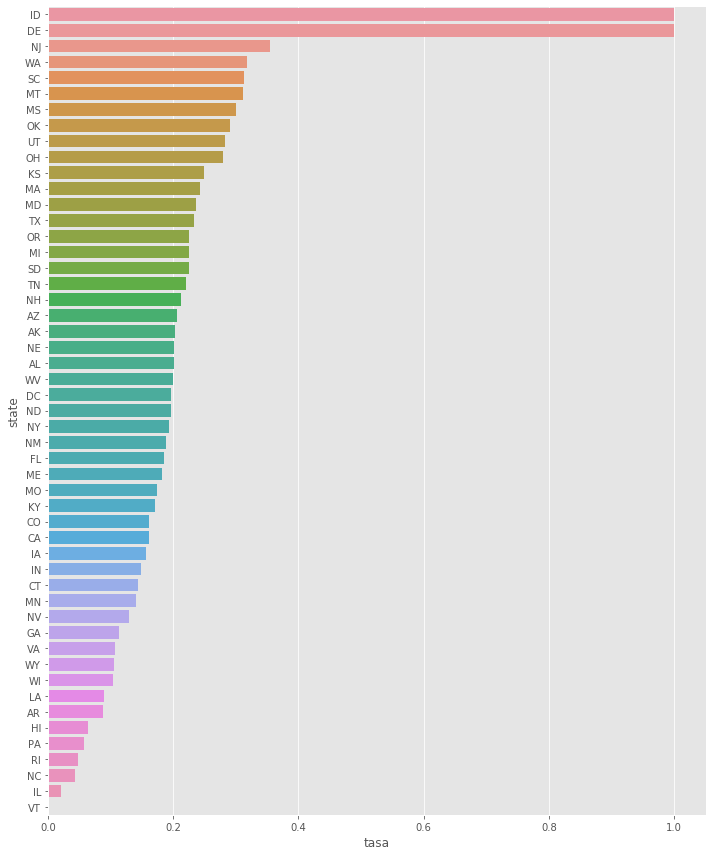

In [23]:
#almacenar predicción en un dataframe y concatenar con datos originales para tener valores de estados

y_pred = pd.DataFrame(
    data=y_hat_proba,
    index=X_test_csv.index,
    columns=["churn_pred_0", "churn_pred_1"]
)

df_pred = pd.concat([churn_pred, y_pred], axis="columns")

# Generar dataframe solo con estados y predicción de churn = 1

df_pred_tasa = df_pred.loc[:, ["state", "churn_pred_1"]]

# Calcula tasa de cambio promedio por estado y grafica

churn_state_pred = df_pred_tasa.groupby(["state"]).mean()
churn_state_pred.columns = ["tasa"]
churn_state_pred.sort_values(by=["tasa"], ascending=False, inplace=True)

plt.figure(figsize=(10, 12))
sns.barplot(x="tasa", y=churn_state_pred.index, data=churn_state_pred)
plt.tight_layout()

### Comentarios:

- Los tres estados con una mayor probabilidad de fuga según la grafica son Montana, New Jersey y Oklahoma.